In [1]:
#pip install pandas numpy matplotlib scikit-learn lifelines seaborn

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [3]:
df = pd.read_csv("Telco_Customer_Churn.csv")
df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [4]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["SeniorCitizen"] = df["SeniorCitizen"].map({1: "Yes", 0: "No"})
df["event"] = df["Churn"].map({"Yes": 1, "No": 0})
df["duration"] = df["tenure"].astype(float)
df.drop(columns=["customerID"], inplace=True)

for c in df.select_dtypes(include="object"):
    df[c] = df[c].replace(" ", np.nan).fillna(df[c].mode()[0])
for c in df.select_dtypes(include=np.number):
    df[c] = df[c].fillna(df[c].median())

df_enc = pd.get_dummies(df, drop_first=True)

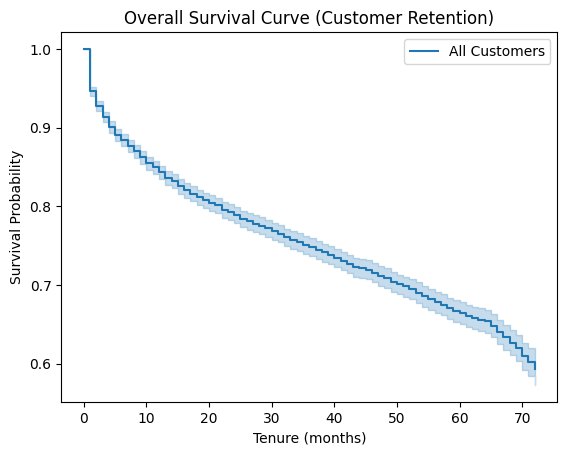

In [5]:
kmf = KaplanMeierFitter()
kmf.fit(df["duration"], df["event"], label="All Customers")
kmf.plot_survival_function()
plt.title("Overall Survival Curve (Customer Retention)")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival Probability")
plt.show()

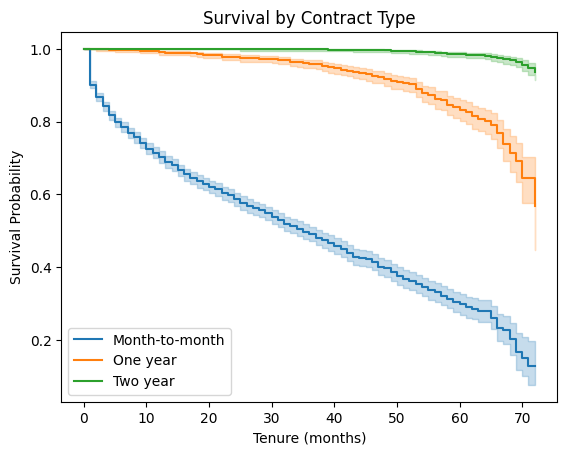

In [6]:

for name, group in df.groupby("Contract"):
    kmf.fit(group["duration"], group["event"], label=name)
    kmf.plot_survival_function()
plt.title("Survival by Contract Type")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

In [7]:
g = df["Contract"].unique()
if len(g) >= 2:
    res = logrank_test(
        df[df["Contract"] == g[0]]["duration"],
        df[df["Contract"] == g[1]]["duration"],
        event_observed_A=df[df["Contract"] == g[0]]["event"],
        event_observed_B=df[df["Contract"] == g[1]]["event"],
    )
    print("Log-rank test:", res.p_value)

Log-rank test: 2.1173266936004908e-203


In [8]:
X = df_enc.drop(columns=["duration", "event"])
y = df_enc[["duration", "event"]]
data = pd.concat([X, y], axis=1)

train, test = train_test_split(data, test_size=0.2, random_state=42)
scaler = StandardScaler()
num_cols = train.select_dtypes(include=np.number).columns.drop(["duration", "event"])
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

cph = CoxPHFitter(penalizer=0.1)
cph.fit(train, duration_col="duration", event_col="event")
print(cph.summary.head(10))


                                    coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                       
tenure                         -0.919394   0.398760  0.037192       -0.992290   
MonthlyCharges                  0.012985   1.013070  0.038223       -0.061931   
TotalCharges                   -0.554607   0.574298  0.036319       -0.625790   
gender_Male                    -0.016405   0.983729  0.044205       -0.103044   
SeniorCitizen_Yes              -0.041993   0.958876  0.054817       -0.149432   
Partner_Yes                    -0.214733   0.806757  0.048129       -0.309063   
Dependents_Yes                 -0.091910   0.912187  0.057633       -0.204868   
PhoneService_Yes                0.119959   1.127450  0.110909       -0.097419   
MultipleLines_No phone service -0.119959   0.886957  0.110909       -0.337336   
MultipleLines_Yes              -0.215130   0.806436  0.049070       -0.311305   

                           

In [9]:

preds = cph.predict_partial_hazard(test)
cidx = concordance_index(test["duration"], -preds, test["event"])
print(f"C-index on test: {cidx:.4f}")


C-index on test: 0.9824


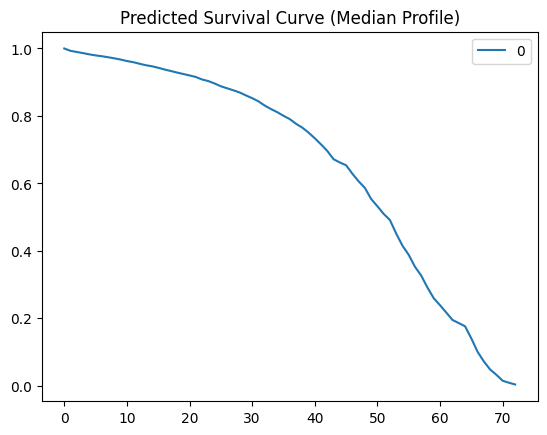

In [10]:
ex = train.drop(columns=["duration", "event"]).median().to_frame().T
surv = cph.predict_survival_function(ex)
surv.plot()
plt.title("Predicted Survival Curve (Median Profile)")
plt.show()


In [11]:
import pickle
# # Assume `cph` is your trained CoxPHFitter object
# with open('best_cph_model.pkl', 'wb') as f:
#     pickle.dump(cph, f)

In [12]:
with open("best_cph_model.pkl", "wb") as f:
    pickle.dump({
        "model": cph,
        "scaler": scaler,
        "columns": train.drop(columns=["duration","event"]).columns.tolist()
    }, f)
    
    